<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Stochastic Approximation</div>

1. [Introduction](#sec1)
2. [Solving a root-finding problem](#sec2)
3. [Optimization Methods](#sec3)
    1. [Finite Difference Stochastic Approximation](#sec3-1)
    2. [Simultaneous Perturbation Stochastic Approximation](#sec3-2)
    3. [Stochastic gradient descent](#sec3-3)
4. [Application to implicit correlation search](#sec4)
    1. [Black-Scholes model](#sec4-1)
    2. [Best-of-Call options](#sec4-2)
    3. [Problem](#sec4-3)
5. [References](#sec5)

<div class="alert alert-success" style="margin-top: 1em">

**Essentials**<br/>
    
Stochastic approximation methods : 
<ul>
<li> Iterative methods that use noisy signals
<li> Allow to estimate properties of unknown functions through noisy observations
<li> Are used in ML to minimise risk/loss functions
<li> Had a major impact in signal processing, pattern recognition, and neural networks 
</ul>
</div>

In [1]:
pip install chaospy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import chaospy as cp

# 1. <a id="sec1"></a> Introduction

In probability theory, a stochastic or random process is a mathematical object defined as a family of random variables. It represents the discreet or continuous evolution of a random variable.

Stochastic approximation methods are iterative methods commonly used for root-finding problems or optimization problems. Stochastic approximation algorithms deal with unknown functions on which we have only access to some measures, with noise. We can't evaluate them directly.

It is useful when trying to find properties of functions representing physical phenomenas, such as zeros and extremas, having access only to measures with noise. This is a daily issue for an engineer (in signal processing for example) hence the frequent use of these algorithms.


#### Example: a function with normally distributed noise

To illustrate the issue we are trying to solve using stochastic approximation methods we are going to define a function disrupted by a background gaussian noise. 

In [3]:
### Functions to use 
def M(x):
    return 0.1*x**2-3*x+5

def noise(x):
    return np.random.normal(M(x))

X = np.linspace(0,30,100)

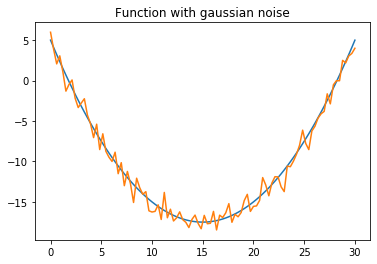

In [4]:
### Graphical representation 
plt.plot(X,M(X))
plt.plot(X,noise(X))
plt.title('Function with gaussian noise')
plt.show()

This basic example already shows that finding with precision the root of  $N(\theta)$ is not easy, nor is finding extremas.

# 2. <a id="sec2"></a> Solving a root-finding problem 

#### Robbins-Monro Algorithm [1]

This algorithm was proposed **in 1951 by Herbert Robbins and Sutton Monro**. It introduces a methodology for solving a root finding problem. 

We have a function $M(\theta)$ and a constant $\alpha$ such that the equation $M(\theta)=\alpha$ has a unique root at $\theta^*$. As stated previously we can't directly obesrve function $M$. We only have access to measures of random variable $N(\theta)$ where $\mathbb E[N(\theta)]=M(\theta)$. In other words $N(\theta)$ is $M(\theta)$ with additionnal gaussian noise. 

As classic stochastic methods, the algorithm is based on iterations on variable $\theta$ such that :

$$\theta_{n+1}=\theta_n-a_n\cdot(N(\theta_n)-\alpha)$$



 $(a_n)$ is a sequence of positive step sizes. It needs to follow the following conditions for $\theta_n$ to converge in $L^2$ :
 
 * $N(\theta)$ is uniformly bounded
 * $M(\theta)$ is non decreasing
 * $M'(\theta^*)$ exists and is positive
 * Sequence $(a_n)$ satisfies : $ \sum\limits_{n=0}^{\infty}a_n = +\infty$ et $\sum\limits_{n=0}^{\infty}a^2_n < +\infty$
 

Condition $\sum a_n = +\infty$ insures that no matter how far from $\theta_0$ the minimum is, the procedure can converge. 

Condition $\sum a_n^2 < +\infty$ forces the step sizes to be a decreasing sequence. This avoids oscillations around the minimum.


According to Blum the later condition ensures convergence with a probability one, as it averages out the noise in $N(\theta)$.

Robbins-Monro suggested the particular sequence $a_n=\frac{a}{n}$ with $a>0$.

<div class="alert alert-warning">
    
**Problem: Solve the root problem given in the introduction using Robbins-Monro algorithm.** <br> 
<ul>
    Parameters to use :    
<ul>   
<li> Starting point $\theta_{0}$
<li> Number of iterations
<li> $\alpha$
<li> Function with gaussian noise
</div> 

In [ ]:
### WRITE YOUR CODE HERE

<div class="alert alert-danger"><a href="#answer1" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer1" class="collapse">


    def Robbins_Monro(theta_0,n_iter,alpha,N):
    
        thetas = np.zeros(n_iter)        
        
        thetas[0] = theta_0
        
        for n in range(1, n_iter):
    
            a_n= 1/n
            
            thetas[n] = thetas[n-1] - a_n*(N(thetas[n-1])-alpha)
            
        return thetas

</div>
</div>

In [ ]:
sol = Robbins_Monro(20,100,0,noise)[-1]

In [ ]:
### Graphical representation
plt.plot(X,noise(X))
plt.plot(X,[0]*len(X),'--')
plt.plot(sol,0,marker='o')
plt.text(sol-3, 0.5, r'$\theta^*$', fontsize = 20)
plt.title('Root problem')
plt.show()

In [ ]:
### Convergence of the algorithm for different starting points
plt.subplot(211)
plt.plot(Robbins_Monro(2,100,0,noise))
plt.title('Convergence of the algorithm')

plt.subplot(212)
plt.plot(Robbins_Monro(20,100,0,noise))

plt.show()

We notice that we can only find one root, that for a $\theta_{0}$ below the first root the algorithm will not work, and that the algorithm is much faster when $\theta_{0}$ is superior to the minima of the function. 
This illustrates Blum's hypothesis that the convergence is more probable if $M(\theta)$ is non-decreasing.

# 3. <a id="sec3"></a> Optimization Methods


### <a id="sec3-1"></a> 3.A. Finite Difference Stochastic Approximation [1]

#### Kiefer-Wolfowitz Algorithm

Kiefer-Wolfowitz algorithm was proposed **in 1952 by Jacob Wolfowitz and Jack Kiefer**. It is highly inspired by Robbins-Monro. However it aims at stochastically finding extremas rather than roots.

Let $M(\theta)$ be a function with an extrema at point $\theta^*$. Same as before we can't directly estimate function $M$ but have access to observations $N$ where $\mathbb E[N(\theta)]=M(\theta)$.

The algorithm follows a gradient-like method, with iterates being generated as follows :
$$\theta_{n+1}=\theta_n-a_n\cdot\left(\frac{N(\theta_n+c_n)-N(\theta_n-c_n)}{2c_n}\right)$$ 

Sequence $\{c_n\}$ is the sequence of **finite difference** widths used for gradient approximation. Sequence $\{a_n\}$ is the size of the steps taken along that direction.

Kiefer and Wolfowitz (and Blum later in 1954) proved that under certain conditions $x_{n}$ will converge in probability to $\theta^*$ as $ n \rightarrow +\infty$.

* $\text{Var}(N(X))\leq S \leq \infty$
* $M(x)$ has a unique maximum (minimum) and is strongly concave (convex)
* $\{a_n\}$ et $\{c_n\}$ must be infinite sequences of positive numbers such that :
    - $c_n \rightarrow 0$ as $ n \rightarrow +\infty$
    
    - $\sum_{n=0}^\infty a_n=+\infty$
    
    - $\sum_{n=0}^\infty a_nc_n< +\infty$
    
    - $\sum_{n=0}^\infty (\frac{a_n}{c_n})^{2}< +\infty$

Under these conditions we can find the extrema of a function $M$ using the noisy observations $N$ available.

The selected sequences $a_n=\frac{1}{n}$ and $c_n=n^{-1/4}$ satisfy the mentionned conditions.

<div class="alert alert-warning">
    
**Problem: Find the extrema of the function given in the introduction using Kiefer-Wolfowitz algorithm.** <br> 
<ul>
    Parameters to use :    
<ul>   
<li> Starting point $\theta_{0}$
<li> Number of iterations
<li> Function with gaussian noise
</div> 

In [ ]:
### WRITE YOUR CODE HERE

<div class="alert alert-danger"><a href="#answer2" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer2" class="collapse">

    def Kiefer_Wolfowitz(theta_0,n_iter,N):

        thetas = np.zeros(n_iter)        

        thetas[0] = theta_0

        for n in range(1, n_iter):
        
            a_n= 1/n
            
            c_n= 1/n**0.25

            thetas[n] = thetas[n-1] - (a_n/(2*c_n))*(N(thetas[n-1]+c_n)-N(thetas[n-1]-c_n))

        return thetas

</div>
</div>

In [ ]:
sol = Kiefer_Wolfowitz(2, 100000, noise)[-1]

In [ ]:
### Graphical representation
plt.plot(X,noise(X))
plt.plot(X,M(X))
plt.plot(sol,M(sol),marker='o')
plt.plot(X,[M(sol)]*len(X),'--')
plt.text(sol, M(sol)+2, r'$\theta^*$', fontsize = 20)
plt.title('Extrema problem')
plt.show()

However for a search space with dimension $d$, Kiefer Wolfowitz algorithm requires at least $d+1$ parameters for each gradient computation. For large dimension spaces convergence might be slow, due to high computational effort per iteration... 

Spall proposed the use of **simultaneous perturbations** to estimate the gradient, leading to the use of only 2 simulations per iteration, whatever the dimension.

### <a id="sec3-2"></a> 3.B. Simultaneous Perturbation Stochastic Approximation [2]


SPSA is a descent method capable to find a global minima. The gradient approximation requires only two measures regardless of the dimension of the optimization problem.

It uses the same iteration process as finite differences:
 
$$\theta_{n+1}=\theta_n-a_n\cdot(\hat{g}_n(\theta_n))$$

We are going to introduce $\Delta_n$, a random perturbation vector.

$$\quad (\hat{g}_n(\theta_n))_i=\dfrac{N(\theta_n+c_n\Delta_n)-N(\theta_n-c_n\Delta_n)}{2c_n(\Delta_n)_i}$$

In finite difference we only perturb one direction at a time, while in simultaneous perturbation the estimator disturbs all directions.

### 3.C. <a id="sec3-3"></a> Stochastic gradient descent [3]


Stochastic gradient descent is used in machine learning when trying to learn the weights of a neural network.

As seen in the neural network class, a neural network with a fixed graph structure is a parametric function $f_\theta$ where $\theta$ is the vector of all parameters (all weights and biases). Learning a neural network that correctly predicts $y$ corresponds to finding the parameters $\theta$ that minimize the following function.
$$L(\theta) = \displaystyle \mathbb{E}_{(x,y)\sim p(x,y)} \left[ \left(f_\theta(x) - y\right)^2 \right] = \int_{x,y} \left[ \left(f_\theta(x) - y\right)^2 \right] \mathrm{d}p(x,y) $$

This is called the **loss or risk function**, it is the delta between our estimation and the optimum. We wish to minimize this delta.

We take a starting point $\theta_0$ for the parameters of $f_\theta$. A plain gradient descent will allow us to reach the optimal $\theta^*$, moving in the opposite direction of the gradient of $L(\theta)$ with respect to $\theta$. 

\begin{align*}
\displaystyle \nabla_\theta L(\theta) &= \nabla_\theta \left[ \mathbb{E}_{(x,y)\sim p(x,y)} \left[ \left(f_\theta(x) - y\right)^2 \right] \right]\\
&= \mathbb{E}_{(x,y)\sim p(x,y)} \left[ \nabla_\theta \left[ \left(f_\theta(x) - y\right)^2 \right] \right]\\
&= \mathbb{E}_{(x,y)\sim p(x,y)} \left[ 2 \left(f_\theta(x) - y\right) \nabla_\theta f_\theta(x) \right]
\end{align*}

$$\nabla_\theta L(\theta) = \int_{x,y} 2 \left(f_\theta(x) - y\right) \nabla_\theta f_\theta(x) \mathrm{d}p(x,y)$$

this expression requires the knowledge of $p(x,y)$ for all possible $(x,y)$ pairs, thus an infinite amount of data. We can try to approximate this gradient with a finite data set $\left\{\left(x_i,y_i\right)\right\}_{i\in [1,N]}$:
$$\nabla_\theta L(\theta) \approx \sum_{i=1}^N 2 \left(f_\theta(x_i) - y_i\right) \nabla_\theta f_\theta(x_i) = g(\theta)$$

This is a noisy estimation of the gradient. We can use **stochastic gradient descent**. 
As stated previously, if $g(\theta)$ is a noisy estimator of $\nabla_\theta L(\theta)$, then the following sequence $\theta_n$ converges to a local minimum of $L(\theta)$:
$$\theta_{n+1} = \theta_n - a_n\cdot g(\theta_n)$$
under the same Robbins-Monro conditions as in part 2.

This allows to find some optimal weights for our network.

# 4. <a id="sec4"></a> Application to implicit correlation search


### 4.A. <a id="sec4-1"></a> Black-Scholes model [4]

An option is a financial derivative that gives the holder the right to trade the underlying asset at a certain date $T$ for a certain price $K$.

**Black, Scholes and Merton** established in **1973** a mathematical model to price such products. Solving the partial differential equation (1) gives a theoretical estimate of the price of these options.

(1) Black-Scholes equation 1D :
$$ \dfrac{\partial V}{\partial t} + \frac{1}{2}\sigma^2X^2\dfrac{\partial^2 V}{\partial^2 X} + rX\dfrac{\partial V}{\partial X} +rV = 0$$

Black-Scholes formula allows to determine the theoretical value $V$ of an option thanks to these parameters :
<ul>
<li> $r$ is the risk free rate
<li> $X$ is the spot price of the underlying asset
<li> $\sigma$ is the volatility of returns
<lu>
The noise will be a random gaussian perturbation on this volatility.

The payoff (value at t = T) of a Call (giving the right to buy the asset) is $ P(X, T) = max(X_{T} - K)_{+} $
<ul>
<li> $K$ is the strike price
<li> $T$ is the maturity time 
<lu>

### 4.B. <a id="sec4-2"></a> Best-of-Call options [5]

In this example we are going to consider an exotic option : Best-of-Call. The return is evaluated on the maximum of two underlying assets. This type of product allows to diversify a portfolio, thus lowering its risk. 

The new PDE is :

$$ \dfrac{\partial V}{\partial t} = - \frac{1}{2}\sigma_{1}^2x_{1}^2\dfrac{\partial^2 V}{\partial^2 x_{1}} - \frac{1}{2}\sigma_{2}^2x_{2}^2\dfrac{\partial^2 V}{\partial^2 x_{2}} - \rho\sigma_{1}\sigma_{2}x_{1}x_{2}\dfrac{\partial^2 V}{\partial x_{1}\partial x_{2}} - rx_{1}\dfrac{\partial V}{\partial x_{1}} - rx_{2}\dfrac{\partial V}{\partial x_{2}}-rV$$

The payoff is the following : $ P(X_{1}, X_{2}, T) = (max(X_{T}^1, X_{T}^2) - K)_{+} $


$\rho$ is the correlation between the two assets.
The more the underlying assets are correlated (Microsoft and Apple) the less the product has chances to end "in the money". If on the other hand you pick assets which are strongly anti-correlated you are more likely yo make money. The fall of an underlying asset will induce the increase of the other one. Thus the product will be more expensive to buy. 

Black Sholes PDE gives the following formulas :
    

$X_{T}^1 = x_{0}^1e^{\mu_{1}T + \sigma_{1}\sqrt(T)Z^1}$

$X_{T}^2 = x_{0}^2e^{\mu_{2}T + \sigma_{2}\sqrt(T)(\rho Z^1 + \sqrt(1-\rho ^2) Z^2)}$

$Z_{n}$ follows a normal distribution.

And the price of the Best of Call satisfies this relation :

$$P_{BoC}(x_{0}^1, x_{0}^2, K, \sigma_{1}, \sigma_{2}, r, \rho, $T$) = e^{-rT}\mathbb E[(max(X_{T}^1, X_{T}^2)-K)_{+}]$$

In this problem the noise will be on the volatility of the asset. It is a quasi-random normal noise $Z_n$ (which we obtain through a transformation of a 2D Halton sequence $H_{n}$) [6, 7]. We use the chaospy library to build this sequence.

$$Z_n = (\sqrt(-2log(H_{n}^1))sin(2\pi H_{n}^2), \sqrt(-2log(H_{n}^1))cos(2\pi H_{n}^2))$$


### 4.C. <a id="sec4-3"></a> Problem

In this problem we want to determine the implicit correlation between two assets knowing the market price of a Best-of-Call product. In other words we want to solve the following equation in $\rho$.

$P_{BoC}(x_{0}^1, x_{0}^2, K, \sigma_{1}, \sigma_{2}, r, \rho, $T$, Z_{n}) = P_{0}^{market}$

To avoid side effects on $\rho$ we will use $\rho = cos(\theta)$.

Extracting the implicit correlation from the market amounts to solving $P(\theta_{n}, Z_{n}) = P_{0}^{market}$.

Here we have access to $P_{0}^{market}$, the option price on the market. We will use a stochastic recursive procedure to solve the inverse problem in $\rho$. 

#### <li> Definition of the the quasi random normal number sequence

In [5]:
size = 300

In [6]:
### 2 dimensional Halton Sequence
H = cp.distributions.sampler.sequences.halton.create_halton_samples(size, dim=2)

In [7]:
Z = np.zeros((2, size))
for i in range(size-1):
    Z[0][i] = sqrt(-2*log(H[0][i]))*np.sin(2*pi*H[1][i])
    Z[1][i] = sqrt(-2*log(H[0][i]))*np.cos(2*pi*H[1][i])

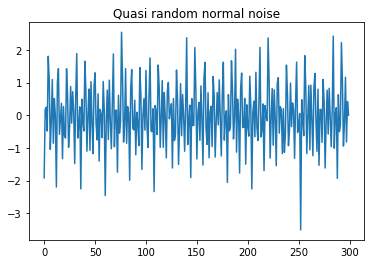

In [8]:
### Graphical representation
X = np.arange(0, size)
plt.plot(X,Z[1])
plt.title('Quasi random normal noise')
plt.show()

#### <li> Definition of the objective function

<div class="alert alert-warning">
    
**Exercise: Write the equation to solve.** <br> 
<ul>
Let's give to the model parameters the following values:
<ul>
   
<li> $x_{0}^1$ = $x_{0}^2$ = 100
<li> r = 0.10
<li> $\sigma_{1}$ = $\sigma_{2}$ = 0.30
    
And for the payoff : $T = 1$, $K = 100$. 

</div> 

<div class="alert alert-warning">
    
**<li> Define $X_{T}^1$ and $X_{T}^2$ .** <br>

</div> 

In [ ]:
### WRITE YOUR CODE HERE

<div class="alert alert-danger"><a href="#answer3" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer3" class="collapse">
    
    def X_1(x_01,K,s1,r,T,rho,size, Z):
        X1 = np.zeros(size)
        mu1 = r - s1**2/2
        for i in range(size) :
            X1[i] = x_01*np.exp(mu1*T + s1*sqrt(T)*Z[0][i])
        return X1

    def X_2(x_02,K,s2,r,T,rho,size, Z):
        X2 = np.zeros(size)
        mu2 = r - s2**2/2
        for i in range(size) :
            X2[i] = x_02*np.exp(mu2*T + s2*sqrt(T)*(rho*Z[0][i] + sqrt(1-rho**2)*Z[1][i]))
        return X2 

</div>
</div>

<div class="alert alert-warning">
    
**<li> Define $P(\theta_{n}, Z_{n})$ .** <br> 

</div> 

In [ ]:
### WRITE YOUR CODE HERE

<div class="alert alert-danger"><a href="#answer4" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer4" class="collapse">

    def P(theta, Z):
    
        x_01 = 100
        x_02 = 100
        r = 0.10
        s1 = 0.30
        s2 = 0.30
        T = 1
        K = 100
    
        X1 = X_1(x_01,K,s1,r,T,cos(theta),size, Z)
        X2 = X_2(x_02,K,s2,r,T,cos(theta),size, Z)
    
        Xmax = np.zeros(size)
        for i in range(size):
            Xmax[i] = max(X1[i], X2[i])
    
        payoff = np.zeros(size)
        for i in range(size):
            payoff[i] = max(Xmax[i]-K, 0)
        
        return np.exp(-r*T)*np.mean(payoff)    

</div>
</div>

We can already use this function to evaluate what should be the market price of our derivative given the correlation between the assets.

In [ ]:
### Price boundaries of our problem
a = P(np.arccos(1), Z)
b = P(np.arccos(-1), Z)
print(a,b)

Given a spot price of 100 at $t=0$, a volatility of 0.30, and a strike price of 100 this result makes sense.

Indeed the holder of this product will exercise it at $t=T$. He will be able to buy the underlying asset for 100. And if the assets are strongly anticorrelated it is more likely that one of them will have be valued at $100 \cdot (1 + 0.30)$. 

#### <li> Recursive procedure
$$\theta_{n+1}=\theta_n-a_{n}\cdot(P(\theta_n, Z_{n})-P_{0}^{market})$$


<div class="alert alert-warning">
    
**Exercise: Solve the optimization.** <br> 
<ul>
The Black-Scholes reference price is $P_{0}^{market} = 30.75$.

For this price we should find a -0.5 correlation [5].

For the stochastic approximation we will use the following conditions :
<ul>
<li> $\theta_{0}$ = 0
<li> $a_{n}$ = $\frac{1}{n}$
</div> 

In [ ]:
### WRITE YOUR CODE HERE

<div class="alert alert-danger"><a href="#answer5" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer5" class="collapse">
    
    def Robbins_Monro_bis(theta_0,n_iter,P_0,P, Z):

        thetas = np.zeros(n_iter)        

        thetas[0] = theta_0

        for n in range(1, n_iter):

            a_n= 1/n

            thetas[n] = thetas[n-1] - a_n*(P(thetas[n-1], Z)-P_0)

        return thetas

</div>
</div>

In [ ]:
sol = Robbins_Monro_bis(0, size, 30.75, P, Z)
np.cos(sol[-1])


$$\rho_{n} = cos(\theta_{n})$$.


In [ ]:
### Graphical representation
X = np.arange(0, size)
plt.plot(X,np.cos(sol))
plt.plot(X,[-0.5]*len(X),'--')
plt.title('Implicit Correlation Search')
plt.show()

#### <li> Results

The graph below represents the evolution of the implicit correlation between two assets in function of the market price of the Best-of-Calls product.

As expected it is decreasing : strongly anti-correlated assets have a good chance of ending "in-the-money" (i.e. $max(X_{T}^1, X_{T}^2) > K$. ) and are thus more expensive.


In [ ]:
A = [Robbins_Monro_bis(0, size, i, P, Z)[-1] for i in np.arange(a, b)]

In [ ]:
B = [np.cos(x) for x in A]

In [ ]:
### Graphical representation
X = np.arange(P(np.arccos(1), Z), P(np.arccos(-1), Z))
plt.plot(X,B)
plt.title('Implicit Correlation = F(price)')
plt.show()

# 5. <a id="sec5"></a> References

[1] : https://en.wikipedia.org/wiki/Stochastic_approximation

[2] : https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation

[3] : https://github.com/erachelson/MLclass

[4] : https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model

[5] : https://pdfs.semanticscholar.org/6b14/d8e7e628dd2d7cb0de5f5b6a4f3d924f2f44.pdf

[6] : https://hal.archives-ouvertes.fr/hal-00504644v4/document

[7] : https://en.wikipedia.org/wiki/Halton_sequence